This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [94]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [95]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21aa4c6a440>)

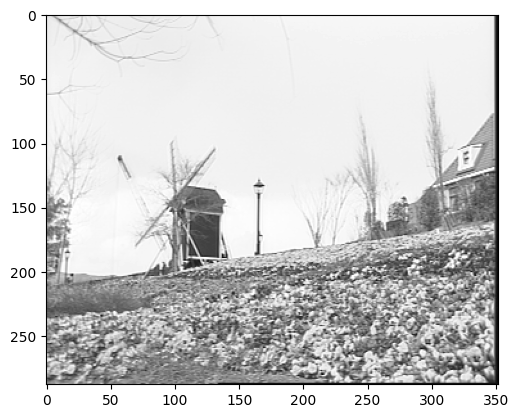

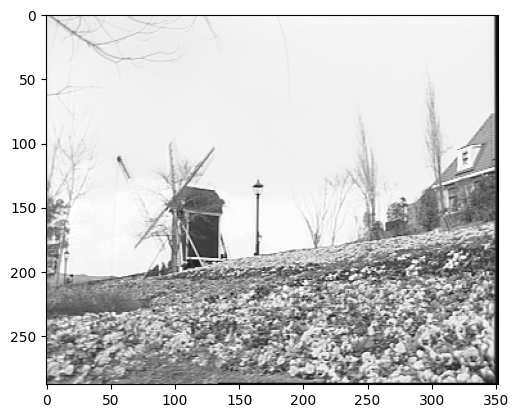

In [96]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [97]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [98]:
#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV

#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV


#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    row_max, col_max = np.shape(cur)

    # Non-regularized search
    if lamb == 0.:
        for row in range(0, row_max,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,col_max,bcol) :
                # current block selection

                B =  cur[row:row+brow,col:col+bcol] # Block

                # Initialization:
                
                costMin = np.inf
                
                Rbest = None
                
                # Loop on candidate displacement vectors

                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range( - search, search): # rcol = candidate displacement vector over the rows
            
                        R = ref_extended[row + extension - drow: row + extension - drow + brow, col + extension - dcol: col + extension - dcol + bcol]

                        cost_tmp = np.sum((B - R)**2)

                        if cost_tmp < costMin :
                            # Save the results if they are better than the previous ones
                            costMin = cost_tmp
                            deplacement_col, deplacement_row = dcol , drow
                            Rbest = R

                            
                mvf[row:row+brow,col:col+bcol,0] = deplacement_row
                mvf[row:row+brow,col:col+bcol,1] = deplacement_col

                # Once the loop is over, save the best column displacement field

                prediction[row:row+brow,col:col+bcol]= Rbest
                
    else: # Regularized search
        for row in range(0, row_max,16) : # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,col_max,16):

                # current block selection
        
                B =  cur[row:row+brow,col:col+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                Rbest = None
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(row,col,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search):# rcol = candidate displacement vector over the rows
                    
        
                        R = ref_extended[row + extension - drow: row + extension - drow + brow, col + extension - dcol: col + extension - dcol + bcol] 
                        cost = np.sum((B - R)**2)+lamb*np.sqrt((drow-pV[0])**2 + (dcol-pV[1])**2)

                        if cost < costMin: # Save the results if they are better than the previous ones

                            costMin = cost

                            deplacement_col, deplacement_row = dcol , drow

                            Rbest = R
                
                
                mvf[row:row+brow,col:col+bcol,0] = deplacement_row # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= deplacement_col # Once the loop is over, save the best column displacement field

                prediction[row:row+brow,col:col+bcol]=Rbest.reshape(brow,bcol) 
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [99]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Using the function displayMVF, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

We observe that in the sky, a lot of movements are detected compared to the previous frame. This is appear because this part of the image is homogenous, it is then sensitive to noise. This masks the "real" movements of objects between the two pictures.

With a smaller search area, the noise erros are much smaller, the result is then better.

In [100]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow)

    
    return

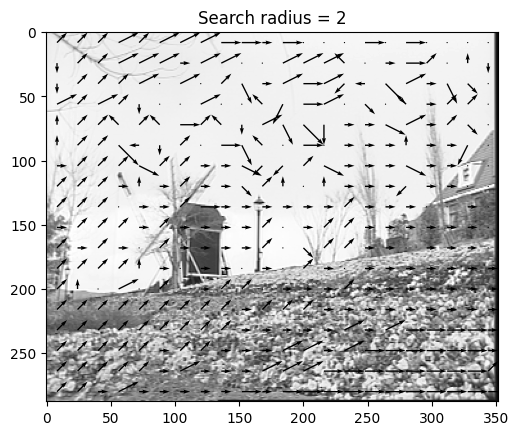

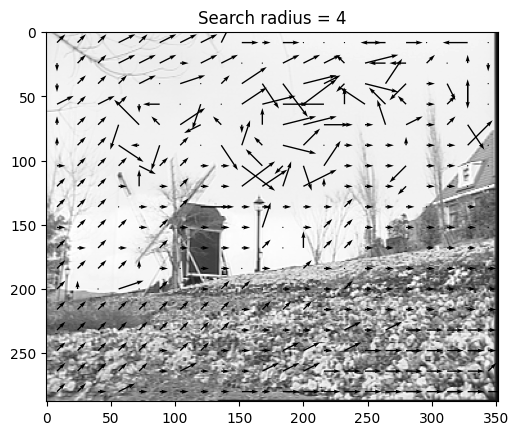

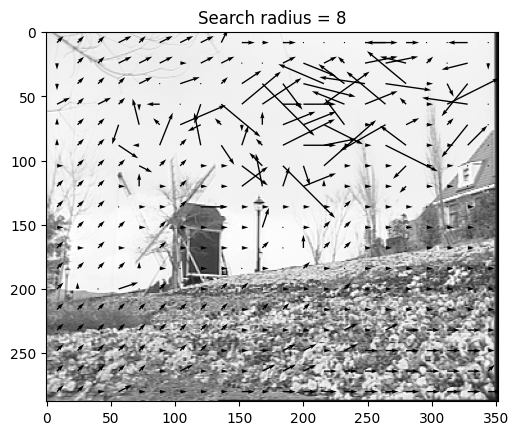

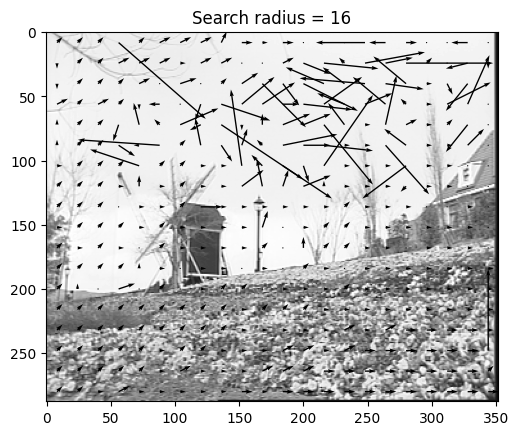

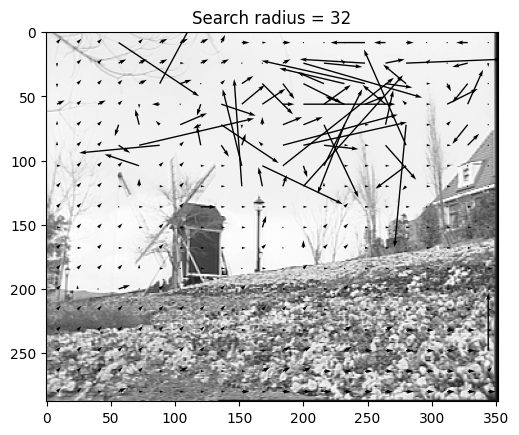

In [101]:
search_radius_list = [2,4,8,16,32]

for search_radius in search_radius_list:
    mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)
    displayMVF(im1,mvf_ssd,brow)
    plt.title('Search radius = '+str(search_radius))

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the fracMc function. Display the motion compensated image. What can you observe ?

We don't have the erros of movement due to the noise now.

In [102]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[:,:,0] # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:,:,1] # Column coordinates, after the movement
    
    extension = outofbound
    #ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)# Padded image
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    
    mc_r = mc_r_tmp + extension # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols+2*extension),np.arange(rows+2*extension)) # Original coordinates, at which we know the data points
    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])    
    
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp =  griddata(points, values, points_inter,'linear')
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21aa4c37bb0>)

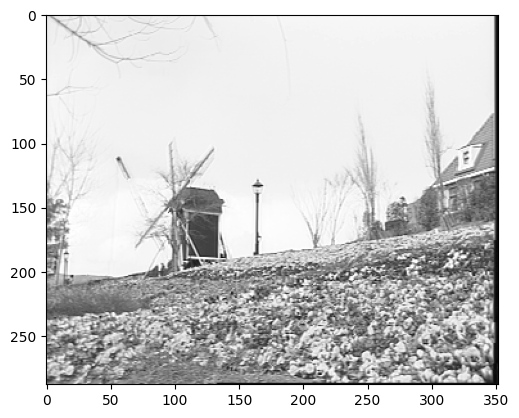

In [103]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

In [104]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    # to prevent dividing by zero
    epsilon = 1e-10

    mse = np.mean((im1 - im2)**2) + epsilon

    # If the images are in 256 greylevels
    PSNR = 10*np.log10(255**2/mse)
    
    return PSNR

In [105]:
psnr_ssd = PSNR(im2,mc_ssd)
print("PSNR: motion compensated and im2", psnr_ssd)

psnr_im12 = PSNR(im2, im1)
print("PSNR: im1 and im2",psnr_im12)

PSNR: motion compensated and im2 22.716629787609975
PSNR: im1 and im2 18.78650932293457


We use the following formula to compute PSNR:

$$ PSNR = 10 log_{10} (\frac{255^2}{MSE}) $$

We want a higher psnr to have the best results, which is obtained between motion compensated image and image 2

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [106]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
     
    row_max, col_max = np.shape(cur)
    
    # Non-regularized search
    if lamb == 0.:
        for row in range(0, row_max,brow) : # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,col_max,bcol) :
                # current block selection

                B =  cur[row:row+brow,col:col+bcol] # Block

                # Initialization:
                
                costMin = np.inf
                
                Rbest = None
                
                # Loop on candidate displacement vectors

                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range( - search, search): # rcol = candidate displacement vector over the rows
            
                        R = ref_extended[row + extension - drow: row + extension - drow + brow, col + extension - dcol: col + extension - dcol + bcol]

                        cost_tmp = np.sum(np.abs(B - R))

                        if cost_tmp < costMin :
                            # Save the results if they are better than the previous ones
                            costMin = cost_tmp
                            deplacement_col, deplacement_row = dcol , drow
                            Rbest = R

                            
                mvf[row:row+brow,col:col+bcol,0] = deplacement_row
                mvf[row:row+brow,col:col+bcol,1] = deplacement_col

                # Once the loop is over, save the best column displacement field

                prediction[row:row+brow,col:col+bcol]= Rbest
        
                
    else: # Regularized search
         for row in range(0, row_max,16) : # for each block in the current image, find the best corresponding block in the reference image
            for col in range(0,col_max,16):

                # current block selection
        
                B =  cur[row:row+brow,col:col+bcol] # Block

                # Initializations          
                
                costMin = np.inf
                Rbest = None
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(row,col,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search):# rcol = candidate displacement vector over the rows
                    
        
                        R = ref_extended[row + extension - drow: row + extension - drow + brow, col + extension - dcol: col + extension - dcol + bcol] 
                        
                        cost = np.sum(np.abs(B - R)) + lamb*np.sqrt((drow-pV[0])**2 + (dcol-pV[1])**2)

                        if cost < costMin: # Save the results if they are better than the previous ones

                            costMin = cost

                            deplacement_col, deplacement_row = dcol , drow

                            Rbest = R
                
                
                mvf[row:row+brow,col:col+bcol,0] = deplacement_row # Once the loop is over, save the best row displacement field
                mvf[row:row+brow,col:col+bcol,1]= deplacement_col # Once the loop is over, save the best column displacement field

                prediction[row:row+brow,col:col+bcol]=Rbest.reshape(brow,bcol) 
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [107]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

There are more erros with SAD

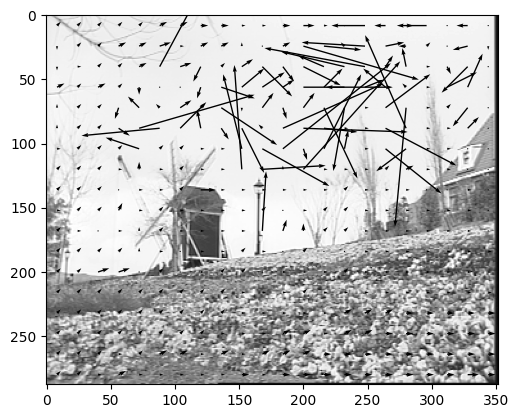

In [108]:
displayMVF(im1,mvf_sad,brow)

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21a8b199780>)

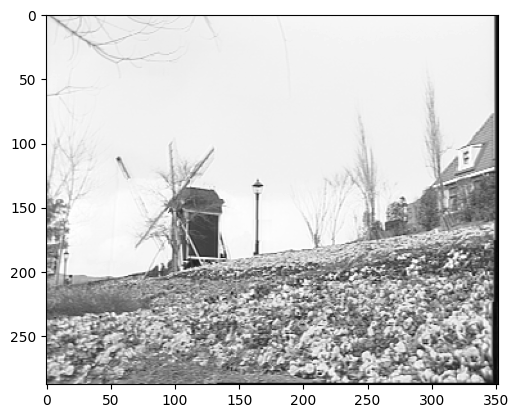

In [109]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [110]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

22.62321683285358


## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

In [111]:
lambdas = np.logspace(-3,3,10)

for lmd in lambdas:
    mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius,lmd)
    mc_sad = fracMc(im1,mvf_sad)
    psnr_sad = PSNR(im2,mc_sad)
    print("For lambda",lmd,"PSNR:",psnr_sad)
    

For lambda 0.001 PSNR: 22.623219846072192
For lambda 0.004641588833612777 PSNR: 22.61306837081522
For lambda 0.021544346900318832 PSNR: 22.61442509344777
For lambda 0.1 PSNR: 22.61145903755196
For lambda 0.46415888336127775 PSNR: 22.586496870374123
For lambda 2.154434690031882 PSNR: 22.49911147701171
For lambda 10.0 PSNR: 21.88864636442147
For lambda 46.41588833612773 PSNR: 21.14010816417201
For lambda 215.44346900318823 PSNR: 21.14010816417201
For lambda 1000.0 PSNR: 21.14010816417201


### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [112]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x21aa680f6d0>)

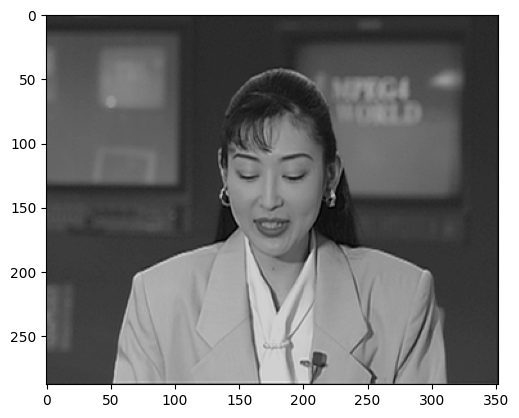

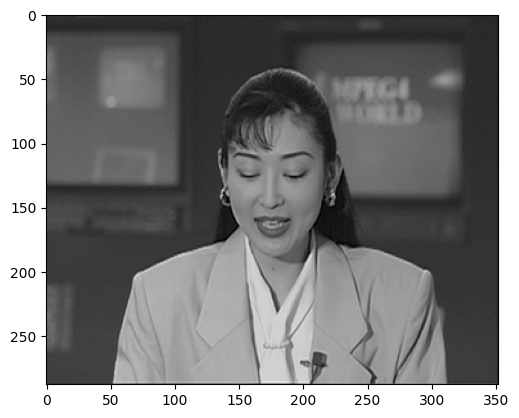

In [113]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [114]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd , prediction = me_ssd(im2,im1,brow,bcol,search_radius)

In [115]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u,kernel_1,'same')
        vAvg =   convolve2d(v,kernel_1,'same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx*(fx*uAvg + fy*vAvg + ft)/(alpha**2 + fx**2 + fy**2)
        v = vAvg - fy*(fx*uAvg + fy*vAvg + ft)/(alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [116]:
alpha = 100
ite = 100

uInitial = mvf_ssd[:,:,1]
vInitial = mvf_ssd[:,:,0] # Rem: pay attention to the inversion of the order compare to me_ssd.

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

The homogeneous parts seem to be still, and not sensitive to noise, the movement of the head is correctly estimated.

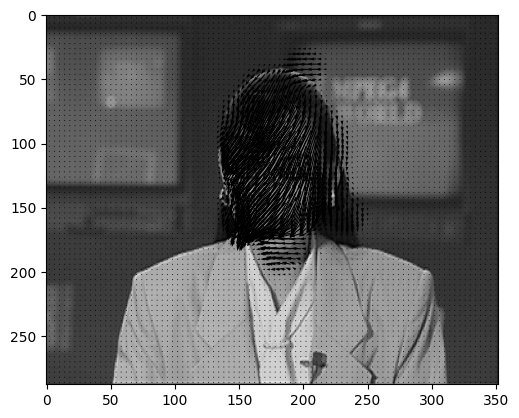

In [117]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [118]:
psnr_hs

41.32807109801667